In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.table_dnn as table_dnn
import model.util as model_util
import torch
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
class_to_letter = dict(enumerate(letters))
letter_to_class = {v : k for k, v in class_to_letter.items()}

classes = [letter_to_class[l] for l in ("X", "O", "Q")]
branch_defs = [
    (("X", "O", "Q"), 0.5, 1),
    (("X",), 0, 0.5),
    (("O", "Q"), 0.4, 0.5),
    (("O",), 0, 0.4),
    (("Q",), 0, 0.4)
]

# classes = [letter_to_class["O"]]
# branch_defs = [(("O",), 0, 1)]

# classes = [letter_to_class[l] for l in letters]
# branch_defs = [(tuple(letters), 0, 1)]

branch_defs = [
    (tuple(map(lambda l: letter_to_class[l], trip[0])), trip[1], trip[2])
    for trip in branch_defs
]

In [4]:
class LetterDataset(torch.utils.data.Dataset):
    def __init__(self):
        data_path = "/gstore/data/resbioai/tsenga5/branched_diffusion/data/letter_recognition/letter-recognition.data"
        
        data = []
        targets = []
        with open(data_path, "r") as f:
            for line in f:
                tokens = line.strip().split(",")
                targets.append(tokens[0])
                data.append(np.array(list(map(int, tokens[1:]))))
        self.data = np.stack(data)
        self.targets = np.array([letter_to_class[l] for l in targets])
        
        # Center/normalize the data
        self.data = (self.data - np.mean(self.data, axis=0, keepdims=True)) / \
            np.std(self.data, axis=0, keepdims=True)
        
    def __getitem__(self, index):
        return torch.tensor(self.data[index]).float(), self.targets[index]
        
    def __len__(self):
        return len(self.targets)
    
dataset = LetterDataset()

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [5]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

In [6]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 1, input_shape)

t_limit = 1
model = table_dnn.MultitaskTabularNet(
    len(branch_defs), input_shape[0], t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/misc"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

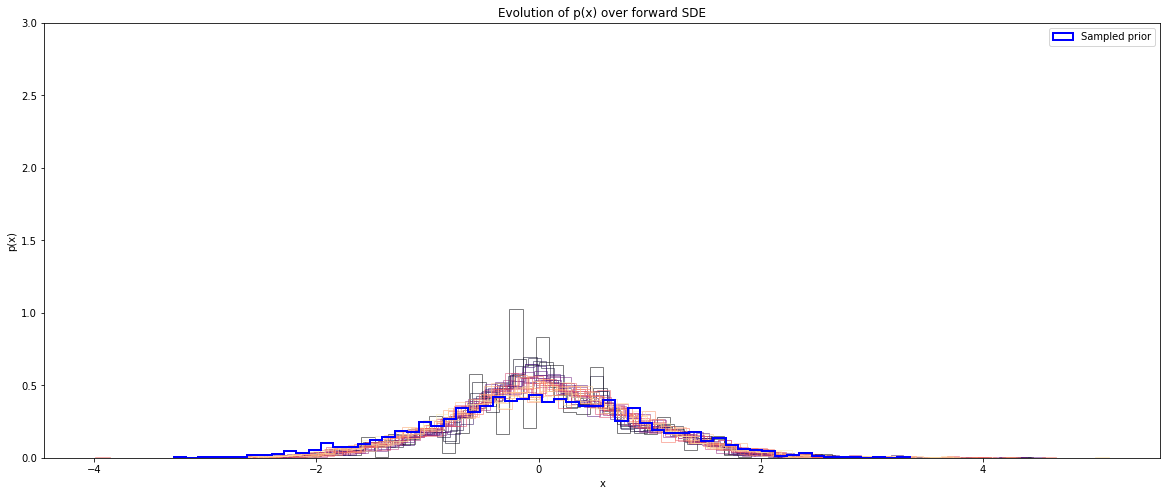

In [7]:
# Show the transformation of the distribution of data to the prior distribution
x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()
x0 = torch.tensor(x0).to(DEVICE)

time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

In [8]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 100,
        "learning_rate": 1e-3,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "38"
Loss: 14.74: 100%|███████████████████████████████████████████| 19/19 [00:01<00:00, 16.08it/s]


Epoch 1 average Loss: 15.59


Loss: 13.08: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.20it/s]


Epoch 2 average Loss: 13.74


Loss: 13.59: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.31it/s]


Epoch 3 average Loss: 12.48


Loss: 12.63: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.48it/s]


Epoch 4 average Loss: 11.85


Loss: 9.50: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.34it/s]


Epoch 5 average Loss: 11.09


Loss: 10.51: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.71it/s]


Epoch 6 average Loss: 11.05


Loss: 11.83: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.18it/s]


Epoch 7 average Loss: 10.65


Loss: 9.36: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.73it/s]


Epoch 8 average Loss: 10.44


Loss: 9.30: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.32it/s]


Epoch 9 average Loss: 10.03


Loss: 9.53: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.44it/s]


Epoch 10 average Loss: 9.98


Loss: 10.06: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.14it/s]


Epoch 11 average Loss: 9.70


Loss: 10.03: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.65it/s]


Epoch 12 average Loss: 9.41


Loss: 10.68: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.15it/s]


Epoch 13 average Loss: 9.54


Loss: 9.49: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.93it/s]


Epoch 14 average Loss: 9.27


Loss: 8.99: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.71it/s]


Epoch 15 average Loss: 9.34


Loss: 9.71: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.42it/s]


Epoch 16 average Loss: 9.22


Loss: 7.73: 100%|████████████████████████████████████████████| 19/19 [00:05<00:00,  3.51it/s]


Epoch 17 average Loss: 9.13


Loss: 11.15: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.21it/s]


Epoch 18 average Loss: 9.28


Loss: 9.72: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.49it/s]


Epoch 19 average Loss: 9.02


Loss: 9.97: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.43it/s]


Epoch 20 average Loss: 9.11


Loss: 9.97: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.25it/s]


Epoch 21 average Loss: 9.00


Loss: 8.92: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.85it/s]


Epoch 22 average Loss: 8.87


Loss: 9.28: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.55it/s]


Epoch 23 average Loss: 8.91


Loss: 7.83: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.19it/s]


Epoch 24 average Loss: 8.70


Loss: 7.49: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.89it/s]


Epoch 25 average Loss: 8.77


Loss: 8.80: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.43it/s]


Epoch 26 average Loss: 8.85


Loss: 10.13: 100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 23.53it/s]


Epoch 27 average Loss: 8.80


Loss: 8.47: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.53it/s]


Epoch 28 average Loss: 8.71


Loss: 8.90: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.98it/s]


Epoch 29 average Loss: 8.68


Loss: 8.04: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.50it/s]


Epoch 30 average Loss: 8.52


Loss: 9.43: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.52it/s]


Epoch 31 average Loss: 8.64


Loss: 8.35: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.54it/s]


Epoch 32 average Loss: 8.62


Loss: 8.28: 100%|████████████████████████████████████████████| 19/19 [00:05<00:00,  3.40it/s]


Epoch 33 average Loss: 8.54


Loss: 9.33: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.31it/s]


Epoch 34 average Loss: 8.60


Loss: 7.00: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.32it/s]


Epoch 35 average Loss: 8.39


Loss: 7.76: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.33it/s]


Epoch 36 average Loss: 8.52


Loss: 8.83: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.50it/s]


Epoch 37 average Loss: 8.53


Loss: 9.02: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.57it/s]


Epoch 38 average Loss: 8.52


Loss: 6.62: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.07it/s]


Epoch 39 average Loss: 8.25


Loss: 8.69: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.17it/s]


Epoch 40 average Loss: 8.28


Loss: 7.29: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.11it/s]


Epoch 41 average Loss: 8.30


Loss: 8.04: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.28it/s]


Epoch 42 average Loss: 8.45


Loss: 8.12: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.68it/s]


Epoch 43 average Loss: 8.36


Loss: 7.43: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.87it/s]


Epoch 44 average Loss: 8.29


Loss: 8.76: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.59it/s]


Epoch 45 average Loss: 8.39


Loss: 9.01: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.29it/s]


Epoch 46 average Loss: 8.38


Loss: 9.00: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.03it/s]


Epoch 47 average Loss: 8.31


Loss: 7.32: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.23it/s]


Epoch 48 average Loss: 8.29


Loss: 7.66: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.50it/s]


Epoch 49 average Loss: 8.21


Loss: 7.99: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.89it/s]


Epoch 50 average Loss: 8.24


Loss: 7.95: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.03it/s]


Epoch 51 average Loss: 8.24


Loss: 8.39: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.11it/s]


Epoch 52 average Loss: 8.23


Loss: 6.77: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.30it/s]


Epoch 53 average Loss: 8.13


Loss: 7.56: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.72it/s]


Epoch 54 average Loss: 8.13


Loss: 9.13: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.04it/s]


Epoch 55 average Loss: 8.31


Loss: 7.58: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.77it/s]


Epoch 56 average Loss: 8.06


Loss: 9.67: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.82it/s]


Epoch 57 average Loss: 8.24


Loss: 8.22: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.95it/s]


Epoch 58 average Loss: 8.23


Loss: 9.55: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.50it/s]


Epoch 59 average Loss: 8.12


Loss: 8.73: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.18it/s]


Epoch 60 average Loss: 8.09


Loss: 7.89: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.21it/s]


Epoch 61 average Loss: 7.99


Loss: 7.92: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.45it/s]


Epoch 62 average Loss: 8.09


Loss: 7.92: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.66it/s]


Epoch 63 average Loss: 8.10


Loss: 7.36: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.83it/s]


Epoch 64 average Loss: 8.08


Loss: 8.67: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.18it/s]


Epoch 65 average Loss: 8.28


Loss: 6.95: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.00it/s]


Epoch 66 average Loss: 8.09


Loss: 8.23: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 21.13it/s]


Epoch 67 average Loss: 7.98


Loss: 6.74: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.75it/s]


Epoch 68 average Loss: 7.94


Loss: 7.44: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.07it/s]


Epoch 69 average Loss: 8.09


Loss: 8.67: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.88it/s]


Epoch 70 average Loss: 7.94


Loss: 8.36: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.76it/s]


Epoch 71 average Loss: 8.08


Loss: 7.87: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.15it/s]


Epoch 72 average Loss: 7.94


Loss: 9.02: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.45it/s]


Epoch 73 average Loss: 7.92


Loss: 5.97: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.90it/s]


Epoch 74 average Loss: 7.86


Loss: 8.26: 100%|████████████████████████████████████████████| 19/19 [00:05<00:00,  3.51it/s]


Epoch 75 average Loss: 8.04


Loss: 9.31: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.33it/s]


Epoch 76 average Loss: 7.91


Loss: 7.23: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 21.80it/s]


Epoch 77 average Loss: 7.89


Loss: 7.08: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.43it/s]


Epoch 78 average Loss: 7.83


Loss: 7.63: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.17it/s]


Epoch 79 average Loss: 7.94


Loss: 7.72: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.22it/s]


Epoch 80 average Loss: 7.79


Loss: 8.59: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.05it/s]


Epoch 81 average Loss: 7.83


Loss: 7.22: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 21.46it/s]


Epoch 82 average Loss: 8.01


Loss: 7.21: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.73it/s]


Epoch 83 average Loss: 7.81


Loss: 8.59: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.78it/s]


Epoch 84 average Loss: 8.00


Loss: 8.89: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.03it/s]


Epoch 85 average Loss: 7.91


Loss: 8.70: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.96it/s]


Epoch 86 average Loss: 7.93


Loss: 8.55: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.45it/s]


Epoch 87 average Loss: 7.91


Loss: 6.65: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.98it/s]


Epoch 88 average Loss: 7.74


Loss: 8.34: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.53it/s]


Epoch 89 average Loss: 7.77


Loss: 6.42: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.33it/s]


Epoch 90 average Loss: 7.67


Loss: 8.18: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 21.95it/s]


Epoch 91 average Loss: 7.77


Loss: 6.45: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.68it/s]


Epoch 92 average Loss: 7.76


Loss: 7.95: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.39it/s]


Epoch 93 average Loss: 7.86


Loss: 7.28: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.35it/s]


Epoch 94 average Loss: 7.58


Loss: 7.65: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.16it/s]


Epoch 95 average Loss: 7.68


Loss: 8.69: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.54it/s]


Epoch 96 average Loss: 7.78


Loss: 6.71: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.70it/s]


Epoch 97 average Loss: 7.81


Loss: 8.66: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 23.43it/s]


Epoch 98 average Loss: 7.74


Loss: 7.72: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 21.87it/s]


Epoch 99 average Loss: 7.61


Loss: 8.96: 100%|████████████████████████████████████████████| 19/19 [00:00<00:00, 22.40it/s]
INFO - train - Completed after 0:04:26


Epoch 100 average Loss: 7.69


### Show generated distributions

In [9]:
samples = {}
for class_to_sample in classes:
    sample = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    ).cpu().numpy()
    samples[class_to_sample] = sample

Class X


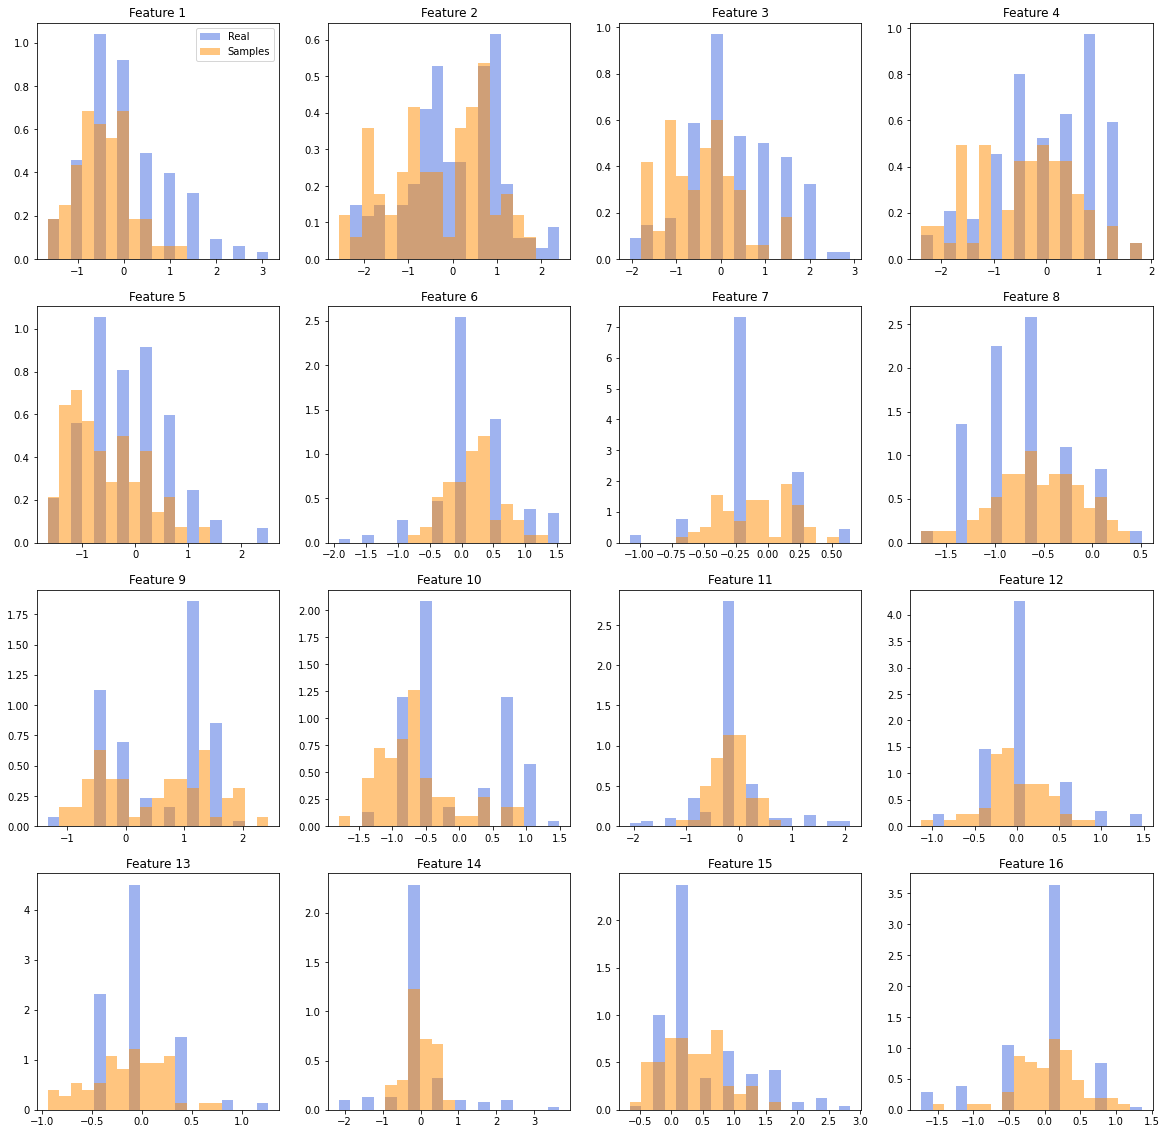

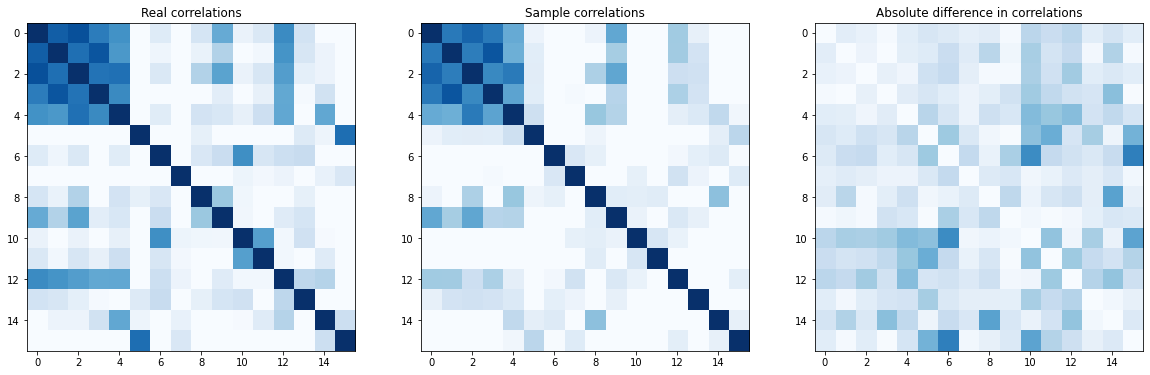

Class O


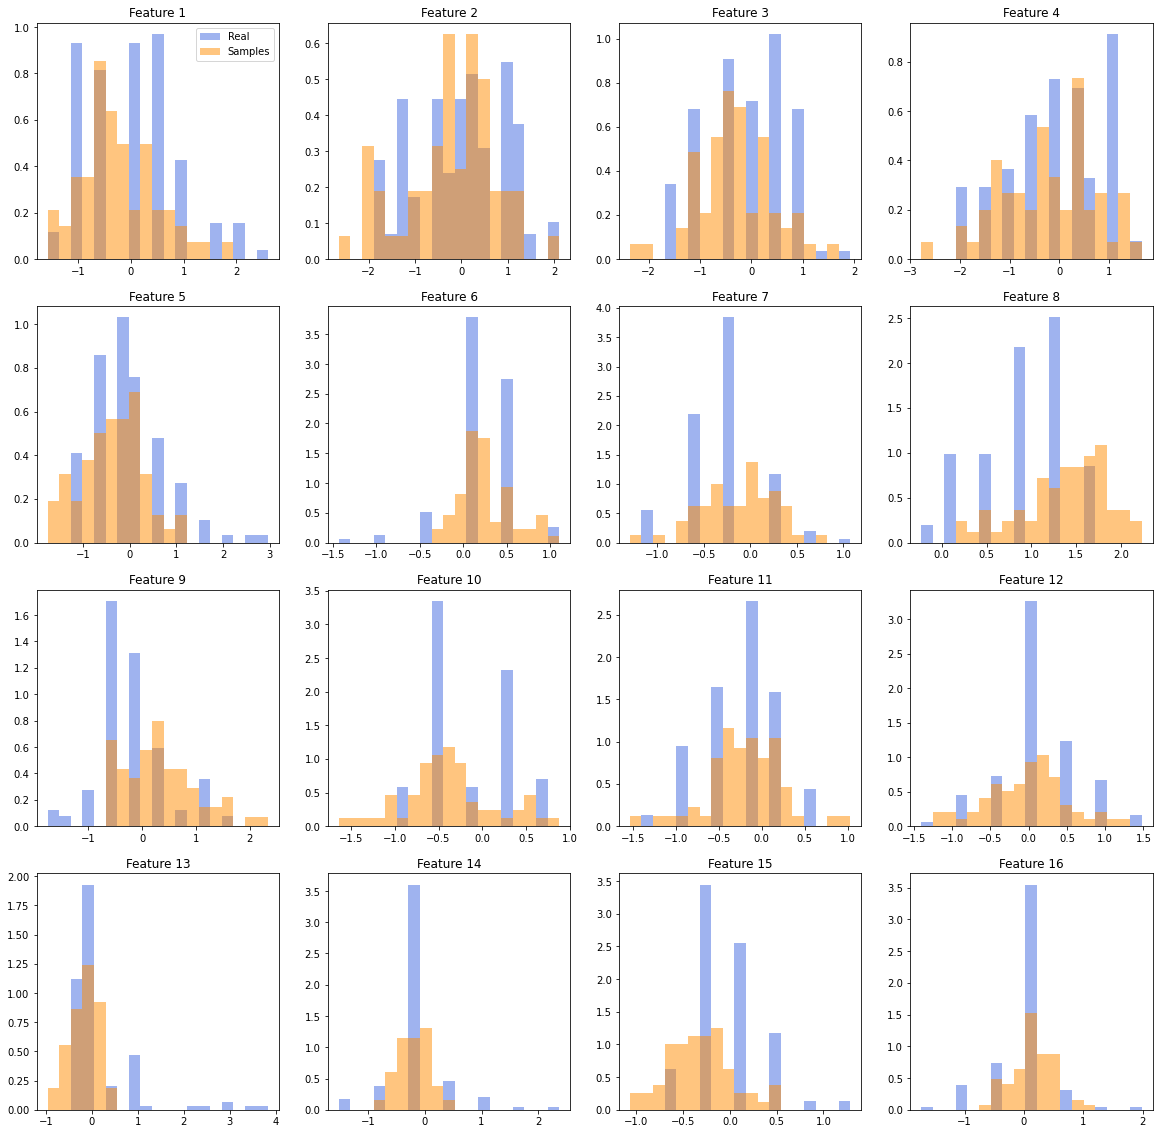

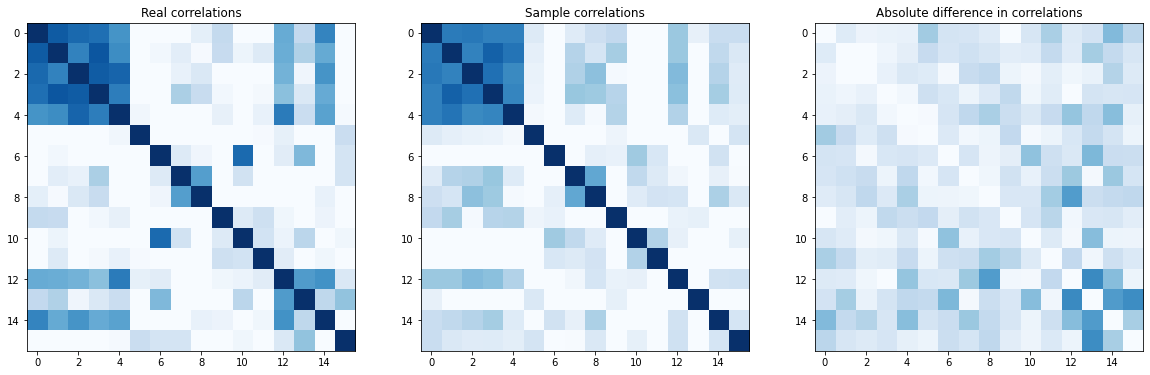

Class Q


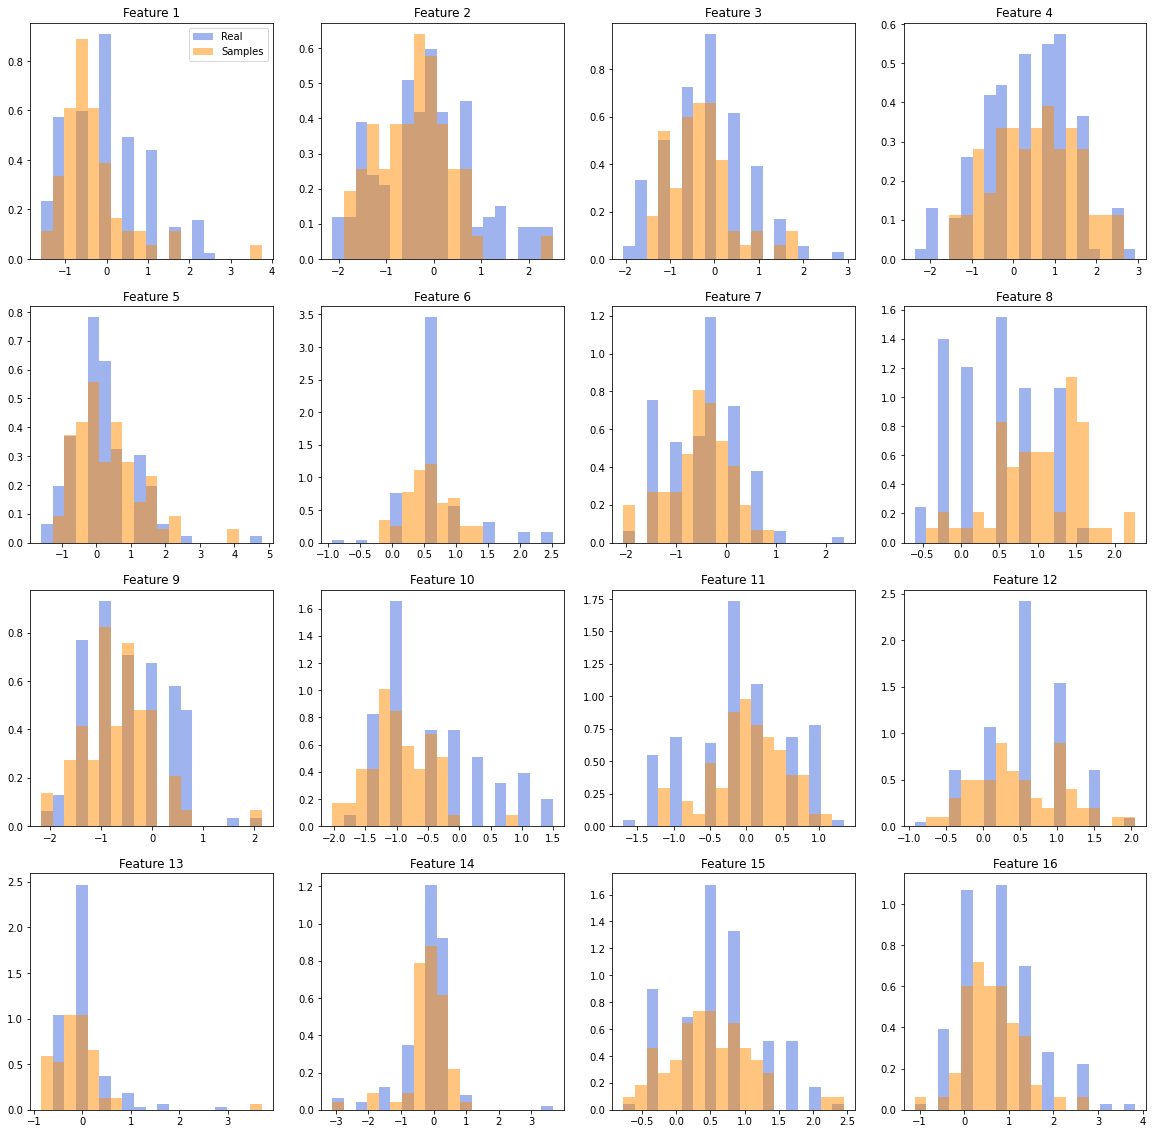

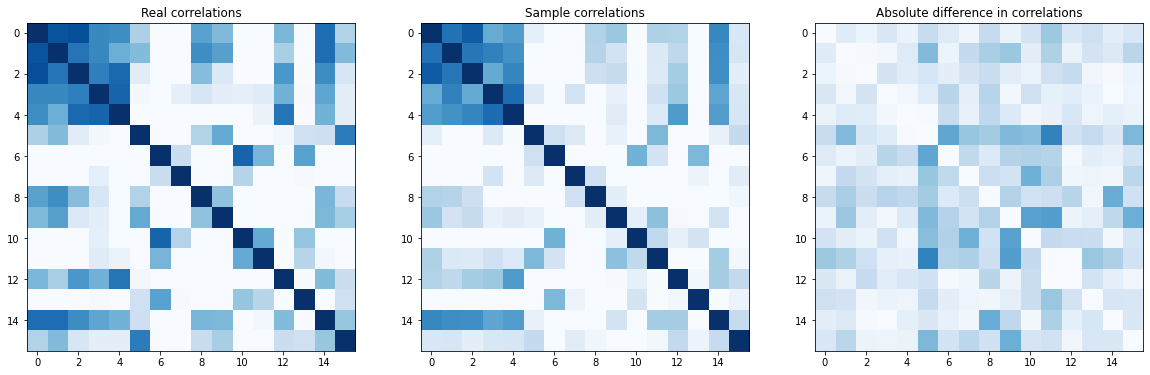

In [10]:
# For simplicity, sample a lot of inputs for the real data
data, targets = [], []
for _ in range(len(classes)):
    x, y = next(iter(data_loader))
    data.append(x.numpy())
    targets.append(y.numpy())
data = np.concatenate([data])
targets = np.concatenate([targets])

for class_to_sample in classes:
    print("Class %s" % class_to_letter[class_to_sample])
    real = data[targets == class_to_sample]
    sample = samples[class_to_sample]
    
    num_features = input_shape[0]
    num_cols = 4
    num_rows = int(np.ceil(num_features / num_cols))
    num_bins = 20

    fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))
    for i in range(num_features):
        r, c = i // num_cols, i % num_cols
        real_vals = real[:, i]
        sample_vals = sample[:, i]
        all_vals = np.concatenate([real_vals, sample_vals])
        bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
        ax[r][c].hist(real_vals, bins=bins, color="royalblue", label="Real", density=True, alpha=0.5)
        ax[r][c].hist(sample_vals, bins=bins, color="darkorange", label="Samples", density=True, alpha=0.5)
        ax[r][c].set_title("Feature %d" % (i + 1))
    ax[0][0].legend()
    plt.show()

    real_corrs = np.empty((num_features, num_features))
    sample_corrs = np.empty_like(real_corrs)
    for i in range(num_features):
        real_corrs[i, i] = 1
        sample_corrs[i, i] = 1
        for j in range(i):
            real_corrs[i, j] = scipy.stats.pearsonr(real[:, i], real[:, j])[0]
            real_corrs[j, i] = real_corrs[i, j]
            sample_corrs[i, j] = scipy.stats.pearsonr(sample[:, i], sample[:, j])[0]
            sample_corrs[j, i] = sample_corrs[i, j]

    fig, ax = plt.subplots(ncols=3, figsize=(20, 10))
    ax[0].imshow(real_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[0].set_title("Real correlations")
    ax[1].imshow(sample_corrs, cmap="Blues", vmin=0, vmax=1)
    ax[1].set_title("Sample correlations")
    ax[2].imshow(np.abs(real_corrs - sample_corrs), cmap="Blues", vmin=0, vmax=1)
    ax[2].set_title("Absolute difference in correlations")
    plt.show()

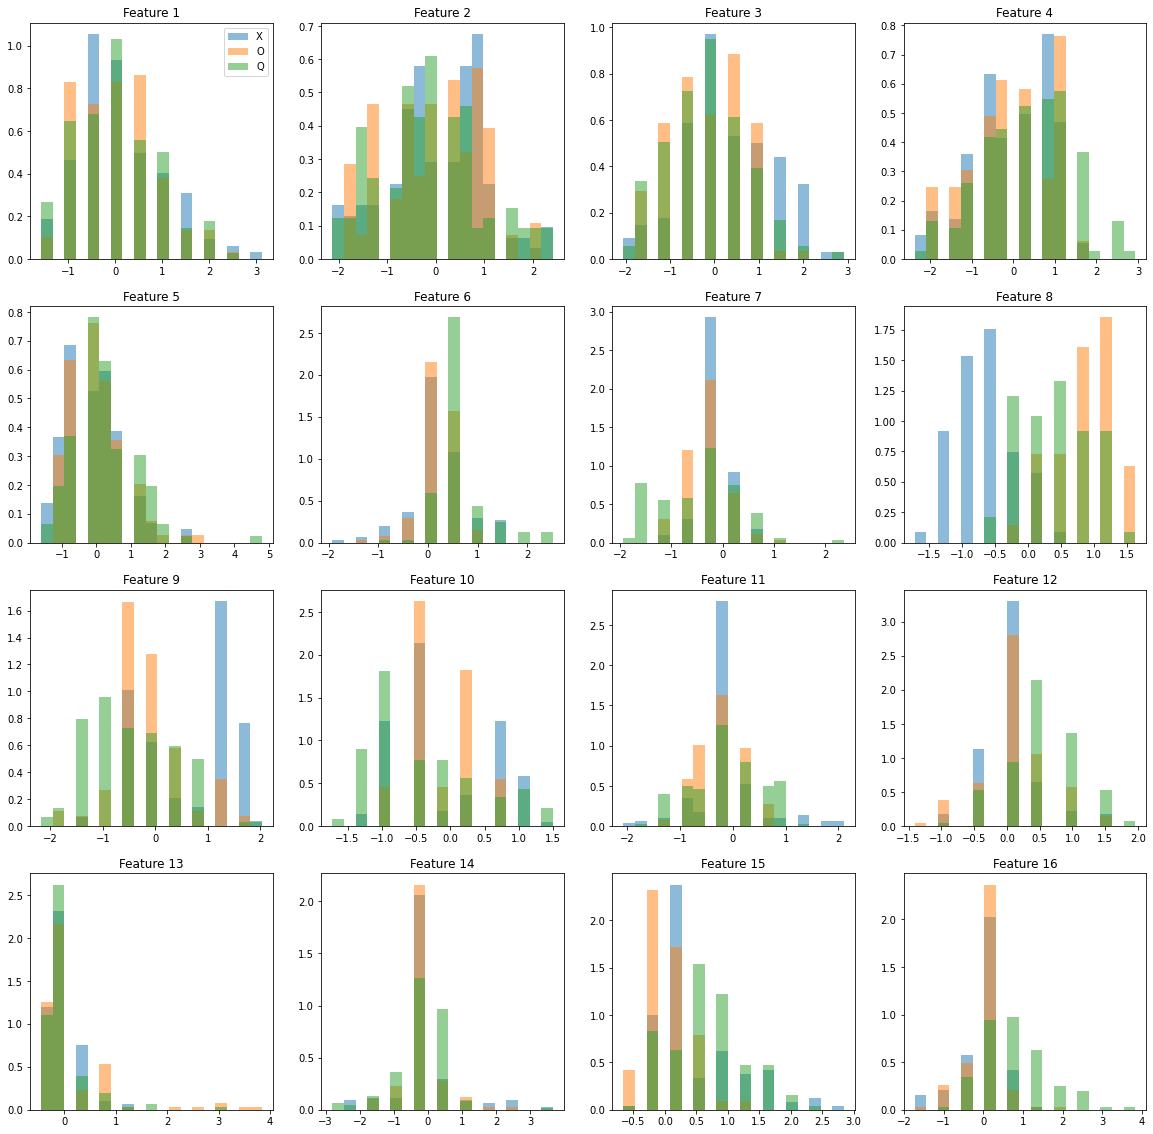

In [11]:
# Plot the distribution of features by class
num_features = input_shape[0]
num_cols = 4
num_rows = int(np.ceil(num_features / num_cols))
num_bins = 20
fig, ax = plt.subplots(ncols=num_cols, nrows=num_rows, figsize=(num_cols * 5, num_rows * 5))

for i in range(num_features):
    r, c = i // num_cols, i % num_cols
    data_to_plot = {}
    for class_to_sample in classes:
        data_to_plot[class_to_sample] = data[targets == class_to_sample][:, i]
    all_vals = np.concatenate(list(data_to_plot.values()))
    bins = np.linspace(np.min(all_vals), np.max(all_vals), num_bins)
    for class_to_sample in classes:
        ax[r][c].hist(
            data_to_plot[class_to_sample], bins=bins, label=class_to_letter[class_to_sample],
            density=True, alpha=0.5
        )
    ax[r][c].set_title("Feature %d" % (i + 1))
ax[0][0].legend()
plt.show()

**Diffusing from one class to another**

O to Q


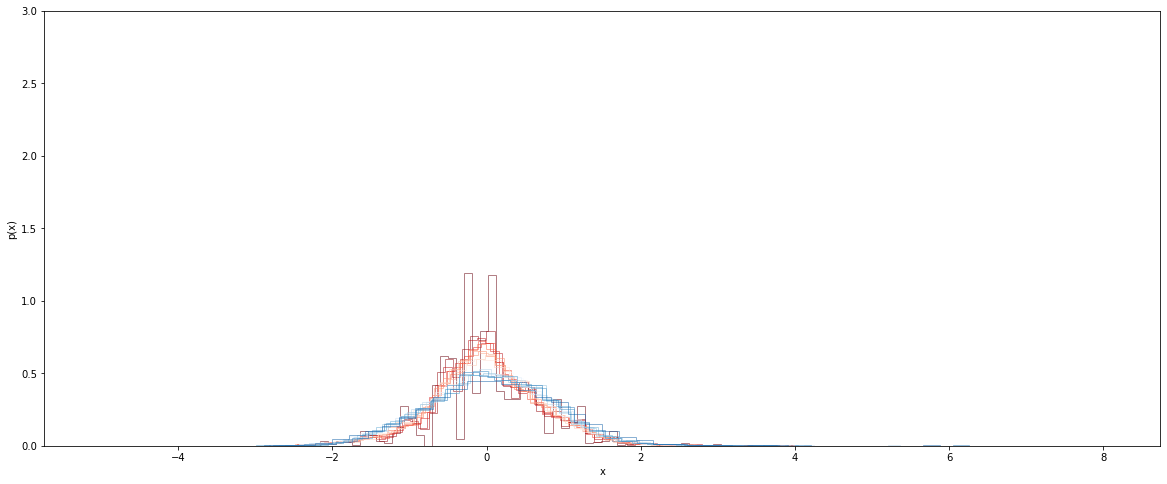

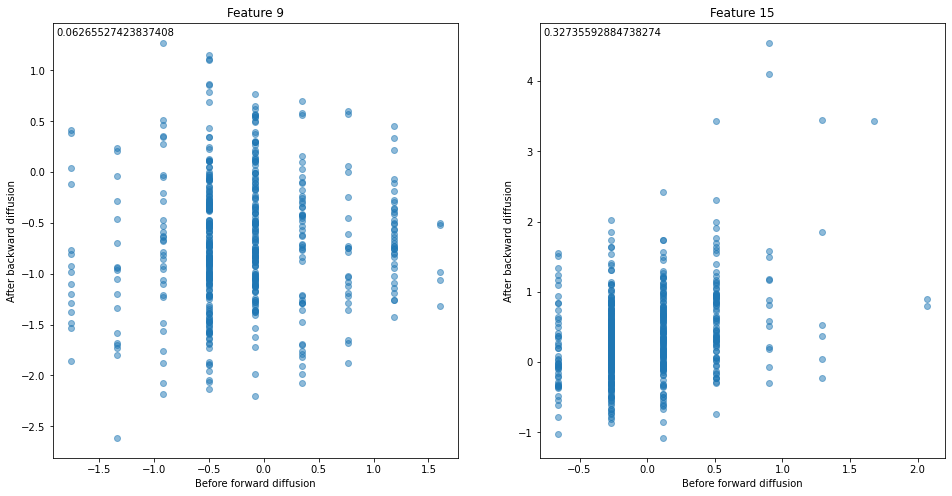

Q to O


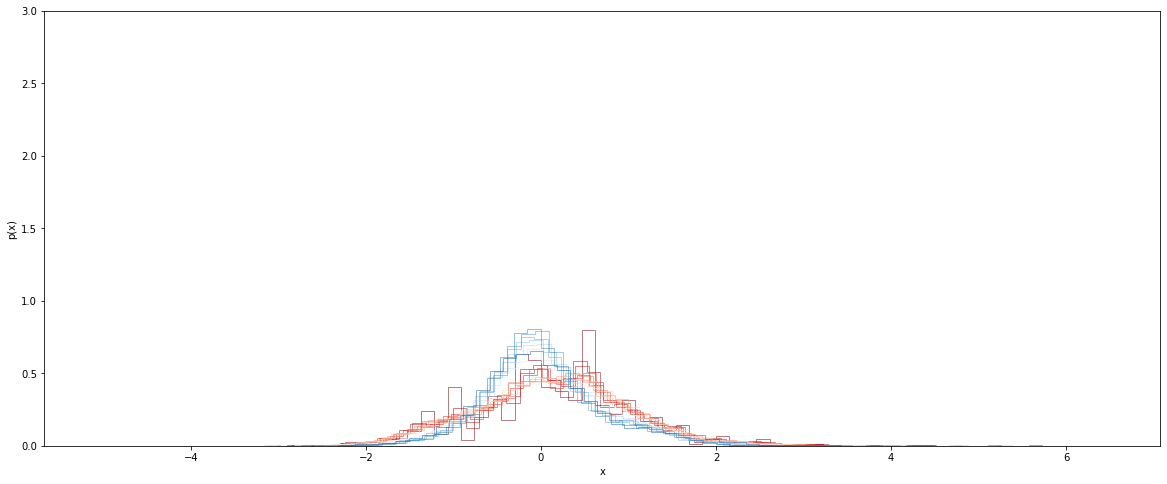

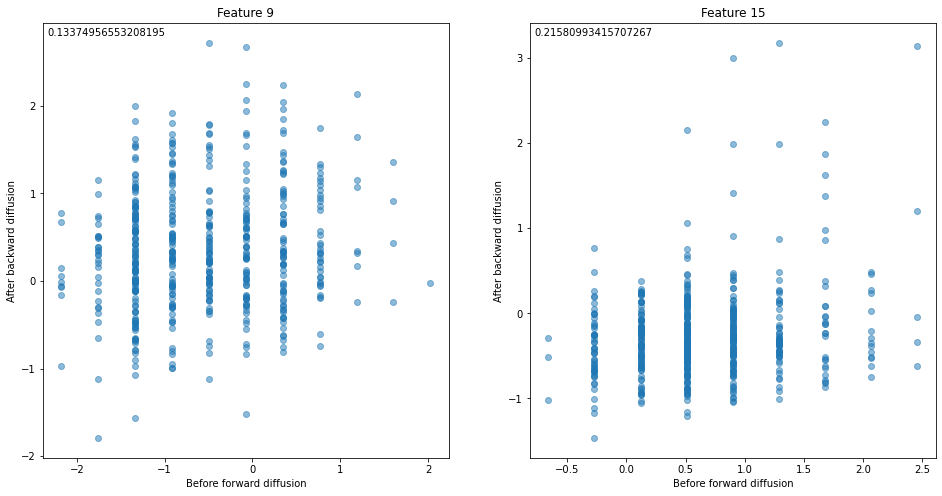

In [28]:
branch_time = 0.4
feature_inds = (8, 14)
c1, c2 = "O", "Q"

orig_c1 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == letter_to_class[c1])[0], size=512, replace=False)
])
orig_c2 = torch.stack([
    dataset[i][0].to(DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == letter_to_class[c2])[0], size=512, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time, time_steps)
forward_c1_to_c2 = np.empty((len(all_t),) + orig_c1.shape)
backward_c1_to_c2 = np.empty((len(all_t) - 1,) + orig_c1.shape)
forward_c2_to_c1 = np.empty((len(all_t),) + orig_c2.shape)
backward_c2_to_c1 = np.empty((len(all_t) - 1,) + orig_c2.shape)
for t_i, t in enumerate(all_t):
    forward_c1_to_c2[t_i] = sde.forward(
        orig_c1, torch.ones(len(orig_c1)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_c2_to_c1[t_i] = sde.forward(
        orig_c2, torch.ones(len(orig_c2)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_c1_to_c2 = torch.tensor(forward_c1_to_c2[-1]).to(DEVICE).float()
last_c2_to_c1 = torch.tensor(forward_c2_to_c1[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_c1_to_c2 = generate.generate_continuous_branched_samples(
        model, sde, letter_to_class[c2], class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_c1.shape[0], initial_samples=last_c1_to_c2,
        num_steps=50
    )
    backward_c1_to_c2[t_i] = last_c1_to_c2.cpu().numpy()
    
    last_c2_to_c1 = generate.generate_continuous_branched_samples(
        model, sde, letter_to_class[c1], class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_c2.shape[0], initial_samples=last_c2_to_c1,
        num_steps=50
    )
    backward_c2_to_c1[t_i] = last_c2_to_c1.cpu().numpy()
    
print("%s to %s" % (c1, c2))
fig, ax = plt.subplots(figsize=(20, 8))
forward_cmap = plt.get_cmap("Reds_r")
backward_cmap = plt.get_cmap("Blues")
for t_i in range(len(all_t)):
    ax.hist(
        np.ravel(forward_c1_to_c2[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
for t_i, t in enumerate(all_t_flip[1:]):
    ax.hist(
        np.ravel(backward_c1_to_c2[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_ylim((0, 3))
plt.show()
fig, ax = plt.subplots(ncols=len(feature_inds), figsize=(8 * len(feature_inds), 8))
for i, f_i in enumerate(feature_inds):
    x, y = forward_c1_to_c2[0][:, f_i], backward_c1_to_c2[-1][:, f_i]
    ax[i].scatter(x, y, alpha=0.5)
    ax[i].text(
        0.01, 0.99, str(scipy.stats.pearsonr(x, y)[0]),
        ha="left", va="top", transform=ax[i].transAxes
    )
    ax[i].set_xlabel("Before forward diffusion")
    ax[i].set_ylabel("After backward diffusion")
    ax[i].set_title("Feature %d" % (f_i + 1))
plt.show()

print("%s to %s" % (c2, c1))
fig, ax = plt.subplots(figsize=(20, 8))
forward_cmap = plt.get_cmap("Reds_r")
backward_cmap = plt.get_cmap("Blues")
for t_i in range(len(all_t)):
    ax.hist(
        np.ravel(forward_c2_to_c1[t_i]), bins=60, histtype="step", color=forward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
for t_i, t in enumerate(all_t_flip[1:]):
    ax.hist(
        np.ravel(backward_c2_to_c1[t_i]), bins=60, histtype="step", color=backward_cmap(t_i / len(all_t)),
        alpha=0.5, density=True
    )
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_ylim((0, 3))
plt.show()
fig, ax = plt.subplots(ncols=len(feature_inds), figsize=(8 * len(feature_inds), 8))
for i, f_i in enumerate(feature_inds):
    x, y = forward_c2_to_c1[0][:, f_i], backward_c2_to_c1[-1][:, f_i]
    ax[i].scatter(x, y, alpha=0.5)
    ax[i].text(
        0.01, 0.99, str(scipy.stats.pearsonr(x, y)[0]),
        ha="left", va="top", transform=ax[i].transAxes
    )
    ax[i].set_xlabel("Before forward diffusion")
    ax[i].set_ylabel("After backward diffusion")
    ax[i].set_title("Feature %d" % (f_i + 1))
plt.show()

In [27]:
for i in range(16):
    x, y = forward_c1_to_c2[0][:, i], backward_c1_to_c2[-1][:, i]
    corr_1 = scipy.stats.pearsonr(x, y)[0]
    x, y = forward_c2_to_c1[0][:, i], backward_c2_to_c1[-1][:, i]
    corr_2 = scipy.stats.pearsonr(x, y)[0]
    print(i + 1, corr_1, corr_2)

1 0.27647046033316036 0.4298699490057134
2 0.2858712289218185 0.41139507079306903
3 0.34431375683449017 0.4341445627436803
4 0.359664037565654 0.4054806229053314
5 0.4150677110978829 0.4999553966773709
6 0.008019436586516094 0.009843836219055819
7 0.08713655044464555 0.0780792771657531
8 0.056196772655401864 0.08512216752447271
9 0.15313775565060295 0.11879651593722862
10 0.030177050411800913 -0.00202951194353828
11 0.09148210645136176 0.09366510384679742
12 0.007127355643466959 0.002791504293148346
13 0.3840022261281558 0.5028764669895025
14 0.20144353478499105 0.32681875960410056
15 0.29337290454182396 0.29659001067183727
16 0.32984752004504947 0.2635913744984728
